In [14]:
# Cell 2 - imports and load data 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

PATH_CSV     = "aggregated_data/weekly_features.csv"

df = pd.read_csv(PATH_CSV, parse_dates=["Date"])
print("Loaded", PATH_CSV)

# Basic checks
DATE_COL = "Date"
TARGET_COL = "total_sales"
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)

print("Observations:", len(df))
display(df.head(3))


Loaded aggregated_data/weekly_features.csv
Observations: 65


,Date,total_sales,n_orders,total_quantity,avg_unit_price,avg_session_duration,avg_pages_viewed,pct_returning,avg_discount_amount,has_discount_rate,...,avg_qty_per_order,unique_customers,orders_per_customer,returning_times_session,discountrate_times_qty,category_share_Electronics,category_share_Home & Garden,category_share_Sports,category_share_Fashion,category_share_Toys
0,2023-01-02,80246.01,67,193,415.496119,14.388060,9.044776,0.582090,43.464328,0.417910,...,2.880597,67,1.000000,8.375139,1.203832,0.519320,0.190078,0.066568,0.090124,0.045320
1,2023-01-09,300235.22,254,763,448.612992,14.500000,9.031496,0.602362,57.833465,0.374016,...,3.003937,252,1.007937,8.734252,1.123520,0.419759,0.197702,0.197547,0.058083,0.042290
2,2023-01-16,281004.20,268,785,393.871791,14.425373,9.000000,0.641791,58.350000,0.402985,...,2.929104,259,1.034749,9.258075,1.180385,0.365671,0.182891,0.203321,0.116558,0.049825


In [15]:
# Cell 3 - configuration and selected features

MIN_HISTORY = 6   # minimum weeks of history required to train/predict
MA_WINDOW = 4     # used only for moving-average fallback or comparison

# conservative initial feature set (adapt if some columns missing)
preferred_features = [
    "week_idx",
    "total_sales_lag_1", "total_sales_lag_2", "total_sales_lag_4",
    "total_sales_rollmean_3", "total_sales_rollmean_4", "total_sales_rollstd_3",
    "total_quantity_lag_1",
    "avg_session_duration_lag_1", "avg_pages_viewed_lag_1", "pct_returning_lag_1",
    "avg_qty_per_order"
]



# keep only features that actually exist in df
features = [f for f in preferred_features if f in df.columns]
print("Using features:", features)


Using features: ['week_idx', 'total_sales_lag_1', 'total_sales_lag_2', 'total_sales_lag_4', 'total_sales_rollmean_3', 'total_sales_rollmean_4', 'total_sales_rollstd_3', 'total_quantity_lag_1', 'avg_session_duration_lag_1', 'avg_pages_viewed_lag_1', 'pct_returning_lag_1', 'avg_qty_per_order']


In [16]:
# Cell 4 - evaluation metrics

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape_robust(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0

def me(y_true, y_pred):
    return float(np.mean(np.array(y_pred) - np.array(y_true)))


In [17]:
# Cell 5 - LightGBM parameters (conservative for small sample size)

lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 12,           # small
    "max_depth": 5,
    "min_data_in_leaf": 6,      # avoid tiny leaves
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l1": 0.0,
    "lambda_l2": 1.0,
    "min_gain_to_split": 0.01,
    "verbosity": -1,
    "seed": 42,
}
NUM_BOOST_ROUND = 300  # moderate number of trees


In [18]:
# Cell 6 — Walk-forward training and prediction for LightGBM
# Produces one-step-ahead predictions starting at index MIN_HISTORY.

dates = df[DATE_COL].values
y = df[TARGET_COL].values
T = len(df)

pred_rows = []   # will hold dicts with Date, actual, lgb_pred, and optionally fallback preds
feat_importance_accum = {f: 0.0 for f in features}

# For logging time
t0 = time.time()
fit_times = []

for t in range(MIN_HISTORY, T):
    train_idx = np.arange(0, t)         # training uses observations 0..t-1
    test_idx  = t                       # predict for time t

    X_train = df.loc[train_idx, features].copy()
    y_train = df.loc[train_idx, TARGET_COL].copy()
    X_test  = df.loc[test_idx, features].copy()   # single-row Series

    # Drop training rows that contain NaNs in feature columns (caused by lags/rolling at start)
    non_na_train_mask = X_train.notna().all(axis=1)
    X_train = X_train.loc[non_na_train_mask]
    y_train = y_train.loc[non_na_train_mask]

    # If training set too small after dropping: skip (occurs for the first few samples)
    if len(X_train) < max( MIN_HISTORY, 4 ):
        continue

    # If test features contain NaN, fallback: use moving average of last MA_WINDOW observed totals
    if X_test.isna().any():
        lgb_pred = float(np.mean(y[train_idx][-MA_WINDOW:]))
        used = "fallback_ma"
        pred_rows.append({"Date": dates[test_idx], "actual": float(y[test_idx]), "lgb_pred": lgb_pred, "train_n": len(X_train), "status": used})
        continue

    # Train LightGBM
    lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
    start = time.time()
    try:
        booster = lgb.train(lgb_params, lgb_train, num_boost_round=NUM_BOOST_ROUND)
        fit_time = time.time() - start
        fit_times.append(fit_time)
        # Predict single row
        lgb_pred = float(booster.predict(X_test.values.reshape(1, -1))[0])
        used = "trained"
        # accumulate gain-based feature importance
        fi = booster.feature_importance(importance_type="gain")
        for f_name, g in zip(features, fi):
            feat_importance_accum[f_name] += g
    except Exception as e:
        # fallback in case training fails
        lgb_pred = float(y[train_idx[-1]])
        used = f"fallback_error:{str(e)[:80]}"
    pred_rows.append({"Date": dates[test_idx], "actual": float(y[test_idx]), "lgb_pred": lgb_pred, "train_n": len(X_train), "status": used})

# timing
t_elapsed = time.time() - t0
print(f"Walk-forward completed in {t_elapsed:.1f}s; average fit time ~ {np.mean(fit_times):.2f}s (on trained steps)")


Walk-forward completed in 1.1s; average fit time ~ 0.02s (on trained steps)


In [19]:
# Cell 7 - results DataFrame and evaluation metrics

results = pd.DataFrame(pred_rows)
# Compute metric on rows where model was trained or fallback (we include all predictions)
mask_valid = results["lgb_pred"].notna()

y_true = results.loc[mask_valid, "actual"].values
y_pred = results.loc[mask_valid, "lgb_pred"].values

metrics = {
    "RMSE": rmse(y_true, y_pred),
    "MAPE(%)": mape_robust(y_true, y_pred),
    "ME": me(y_true, y_pred),
    "N_preds": len(y_pred)
}
print("LightGBM walk-forward metrics:")
for k,v in metrics.items():
    print(f"  {k}: {v}")
results

LightGBM walk-forward metrics:
  RMSE: 46722.614683533495
  MAPE(%): 10.573211960264176
  ME: -6211.580590260925
  N_preds: 55


,Date,actual,lgb_pred,train_n,status
0,2023-03-13,323682.07,332039.614583,6,trained
1,2023-03-20,313631.01,330845.678571,7,trained
2,2023-03-27,390888.82,328693.843750,8,trained
3,2023-04-03,320561.13,335604.395833,9,trained
4,2023-04-10,318879.66,334100.068750,10,trained
5,2023-04-17,456454.26,332716.394886,11,trained
6,2023-04-24,316921.01,338691.714446,12,trained
7,2023-05-01,324367.17,348211.207840,13,trained
8,2023-05-08,352596.79,334413.338318,14,trained
9,2023-05-15,335039.45,306278.814508,15,trained


In [20]:
# Cell 8 - compute moving average baseline for same evaluation points and compare

ma_preds = []
for i, row in results.iterrows():
    # find index of date in df
    date = row["Date"]
    idx = df.index[df[DATE_COL] == date][0]
    if idx >= MA_WINDOW:
        ma_pred = float(np.mean(df.loc[idx-MA_WINDOW:idx-1, TARGET_COL].values))
    else:
        ma_pred = float(df.loc[:idx-1, TARGET_COL].iloc[-1])  # fallback last observed
    ma_preds.append(ma_pred)

results["moving_avg"] = ma_preds

# Metrics for moving average
y_pred_ma = results["lgb_pred"].values
metrics_ma = {"RMSE": rmse(y_true, y_pred_ma), "MAPE(%)": mape_robust(y_true, y_pred_ma), "ME": me(y_true, y_pred_ma)}
print("Moving-average metrics on same evaluation points:")
for k,v in metrics_ma.items():
    print(f"  {k}: {v}")


Moving-average metrics on same evaluation points:
  RMSE: 46722.614683533495
  MAPE(%): 10.573211960264176
  ME: -6211.580590260925


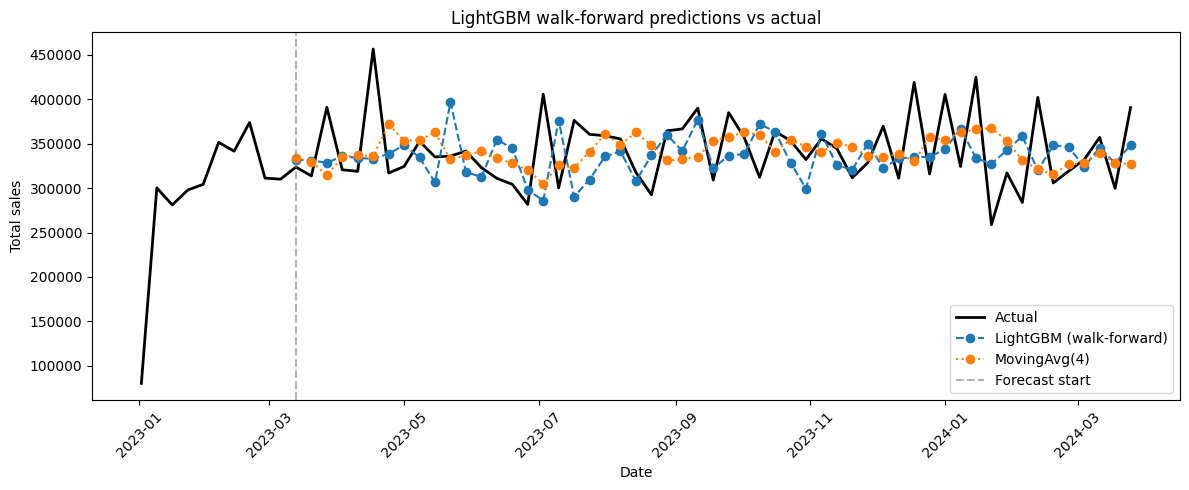

In [21]:
# Cell 9 - visualization

plt.figure(figsize=(12,5))
# plot full actual series
plt.plot(df[DATE_COL], df[TARGET_COL], label="Actual", color="black", linewidth=2)

# overlay LightGBM preds (predictions start at MIN_HISTORY)
plt.plot(results["Date"], results["lgb_pred"], label="LightGBM (walk-forward)", marker="o", linestyle="--")
plt.plot(results["Date"], results["moving_avg"], label=f"MovingAvg({MA_WINDOW})", marker="o", linestyle=":")
plt.axvline(results["Date"].iloc[0], color="grey", linestyle="--", alpha=0.6, label="Forecast start")
plt.xlabel("Date")
plt.ylabel("Total sales")
plt.title("LightGBM walk-forward predictions vs actual")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
# Cell 10 - aggregated feature importances (gain sum)

# Normalize importance by number of trained steps to get average gain per trained model
n_trained_steps = sum(1 for r in pred_rows if r["status"] == "trained")
fi_df = pd.DataFrame({
    "feature": list(feat_importance_accum.keys()),
    "gain_sum": list(feat_importance_accum.values())
}).sort_values("gain_sum", ascending=False)

if n_trained_steps > 0:
    fi_df["gain_avg"] = fi_df["gain_sum"] / n_trained_steps
else:
    fi_df["gain_avg"] = 0.0

display(fi_df.head(20))


,feature,gain_sum,gain_avg
3,total_sales_lag_4,4.472283e+12,8.131424e+10
11,avg_qty_per_order,4.157073e+12,7.558314e+10
1,total_sales_lag_1,3.256401e+12,5.920729e+10
6,total_sales_rollstd_3,2.844886e+12,5.172521e+10
9,avg_pages_viewed_lag_1,2.207129e+12,4.012962e+10
7,total_quantity_lag_1,1.834876e+12,3.336138e+10
8,avg_session_duration_lag_1,1.771040e+12,3.220072e+10
0,week_idx,1.692173e+12,3.076677e+10
2,total_sales_lag_2,1.435782e+12,2.610512e+10
10,pct_returning_lag_1,1.407993e+12,2.559988e+10


In [23]:
# Cell 11 - save results and importances for reporting
results.to_csv("lgb_walk_forward_predictions.csv", index=False)
fi_df.to_csv("lgb_feature_importance.csv", index=False)
print("Saved lgb_walk_forward_predictions.csv and lgb_feature_importance.csv")


Saved lgb_walk_forward_predictions.csv and lgb_feature_importance.csv


In [24]:
# ================================
# Feature importance (LightGBM)
# ================================

import pandas as pd
import matplotlib.pyplot as plt

# Ensure model is a LightGBM Booster
assert hasattr(booster, "feature_importance"), "Model must be a LightGBM Booster."

importance_df = pd.DataFrame({
    "feature": booster.feature_name(),
    "gain": booster.feature_importance(importance_type="gain"),
    "split_count": booster.feature_importance(importance_type="split")
})

importance_df = importance_df.sort_values("gain", ascending=False).reset_index(drop=True)

print("Top features by gain:")
display(importance_df.head(15))

print("Number of features never used:",
      (importance_df["gain"] == 0).sum())


Top features by gain:


,feature,gain,split_count
0,total_sales_lag_1,1.488348e+11,186
1,total_sales_rollstd_3,1.301700e+11,136
2,avg_qty_per_order,1.234704e+11,114
3,total_sales_lag_4,1.158782e+11,153
4,pct_returning_lag_1,1.012762e+11,150
5,avg_session_duration_lag_1,7.401849e+10,200
6,total_quantity_lag_1,6.715835e+10,113
7,avg_pages_viewed_lag_1,5.871204e+10,117
8,week_idx,5.625697e+10,134
9,total_sales_lag_2,3.986967e+10,122


Number of features never used: 0
